In [1]:
import numpy as np 
from scipy import stats 
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.colors as colors
import sys
from iminuit import Minuit
import pandas as pd
from scipy.special import comb


In [2]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH, simpson38
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

In [3]:
def setMplParam(classNum):
    COLOUR = ['#1E90FF', '#FFBF00', '#FF6347', '#00A86B', '#5A4FCF','#D473D4', '#00CCFF']
    LINE = ['--', '-', '-.', '-', ':', '--','-']
    MARKER = ['o', '*', '^', 's', '.', 'p', 'o']
    COLOUR_EFF = COLOUR[:classNum]
    LINE_EFF = LINE[:classNum]
    MARKER_EFF = MARKER[:classNum]
    plt.rcParams['axes.prop_cycle'] = (plt.cycler(color=COLOUR_EFF) +
                                        plt.cycler(linestyle=LINE_EFF) +
                                        plt.cycler(marker=MARKER_EFF))
    plt.rcParams['lines.markersize'] = 5  # Example size
    plt.rcParams['lines.linewidth'] = 2  # Example width

    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.titlesize'] = 20

    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.labelsize'] = 20
    
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.labelsize'] = 20
    
    plt.rcParams['legend.fontsize'] = 12

    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.8
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.linewidth'] = 1

    mpl.rcParams['axes.linewidth'] = 2

    mpl.rcParams['xtick.major.size'] = 7
    mpl.rcParams['xtick.major.width'] = 3
    mpl.rcParams['xtick.minor.size'] = 2
    mpl.rcParams['xtick.minor.width'] = 2

    mpl.rcParams['ytick.major.size'] = 7
    mpl.rcParams['ytick.major.width'] = 3
    mpl.rcParams['ytick.minor.size'] = 2
    mpl.rcParams['ytick.minor.width'] = 2

setMplParam(6)

In [4]:
def getPosterior(llh, prior, given):
    return llh * prior / given

In [5]:
def probRadioLoud(): # +/-    theta
    p_T_loud = 0.8 # loud given loud
    p_F_loud = 0.3 # not loud given loud
    prior_loud = 0.1 # loud 
    prior_non_loud = 0.9 # not loud  
    marginal = (p_T_loud * prior_loud + p_F_loud * prior_non_loud)
    p_true_loud = getPosterior(p_T_loud, prior_loud, marginal)
    print(f'{p_true_loud}')
probRadioLoud()

0.2285714285714286


 
`hyperGeo`: the probability of 
* `k` successes
* in `n` draws, without replacement, 
* from a finite population of size `N` 
* that contains exactly `K` objects with that feature
  * `K` the number of success states in the population

In [6]:
def pmf(N, K, n, k):
    return comb(K, k) * comb(N-K, n-k) / comb(N, n)

In [7]:
def plotPosterior(N, p1, p2, label1, label2):
    fig, ax = plt.subplots(figsize = (14,8))
    ax.plot(N, p1, label = label1)
    ax.plot(N, p2, label = label2)
    ax.set_xlabel('N')
    ax.set_ylabel('Posterior')
    ax.set_title('Posterior of the total population')
    ax.legend()
    max_N_1 = N[np.argmax(p1)]
    max_N_2 = N[np.argmax(p2)]
    print(f'max posterior : {max_N_1},   {max_N_2}')

max posterior : 600,   400


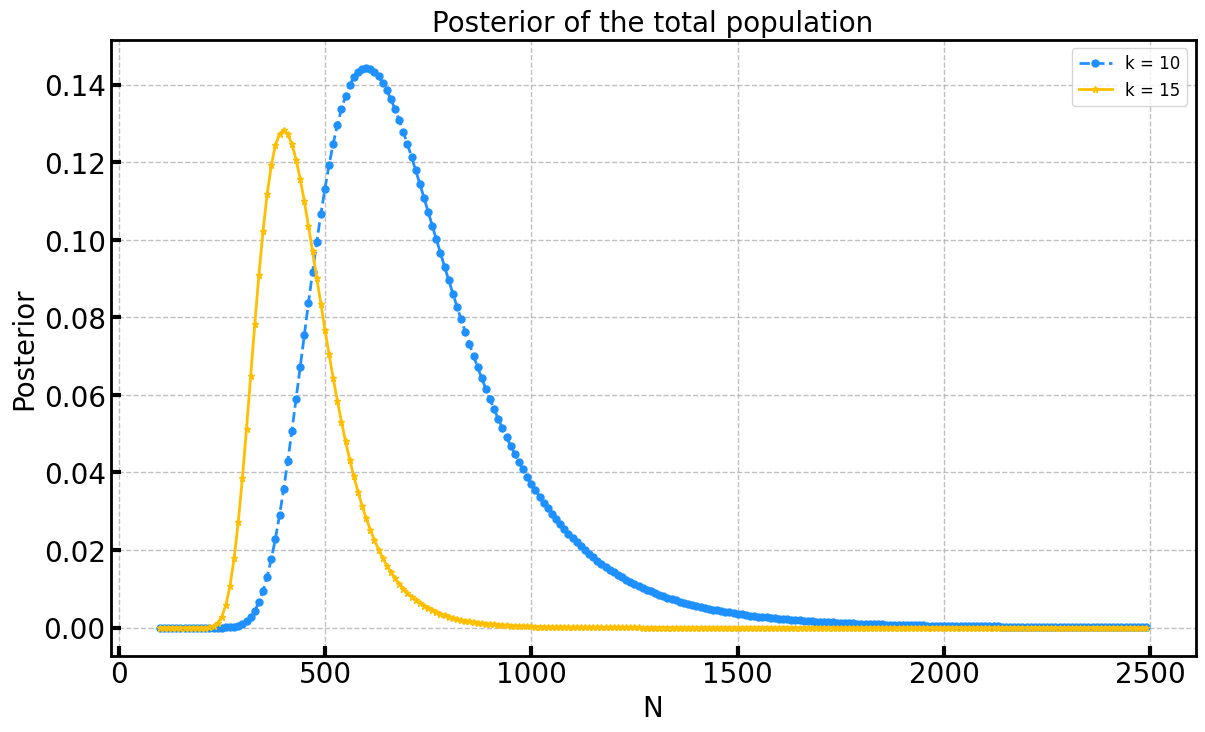

In [8]:
def populationFlat():
    N = np.arange(100,2500,10)
    n = 60 # quantity drawn in each trial
    K = 100  # the number of success states in the population
    k1 = 10  # the number of observed successes
    k2 = 15  # the number of observed successes
    llh1 = pmf(N, K, n, k1)
    llh2 = pmf(N, K, n, k2)
    
    marginal = 1
    p1 = getPosterior(llh1, 1, marginal)
    p2 = getPosterior(llh2, 1, marginal)
    plotPosterior(N, p1, p2, 'k = 10', 'k = 15')

    # print(f'{max}')
populationFlat()

In [9]:
def fractional(x):
    return 1/x

In [10]:
def plotLLH(N, llh1, llh2, label1, label2):
    fig, ax = plt.subplots(figsize = (14,8))
    ax.plot(N, llh1, label = label1)
    ax.plot(N, llh2, label = label2)
    ax.set_xlabel('N')
    ax.set_ylabel('Likelihood')
    ax.set_title('Likelihood of the total population')
    ax.legend()
    max_N_1 = N[np.argmax(llh1)]
    max_N_2 = N[np.argmax(llh2)]
    print(f'max LLH : {max_N_1},   {max_N_2}')

559
max LLH : 599,   400
max posterior : 559,   384


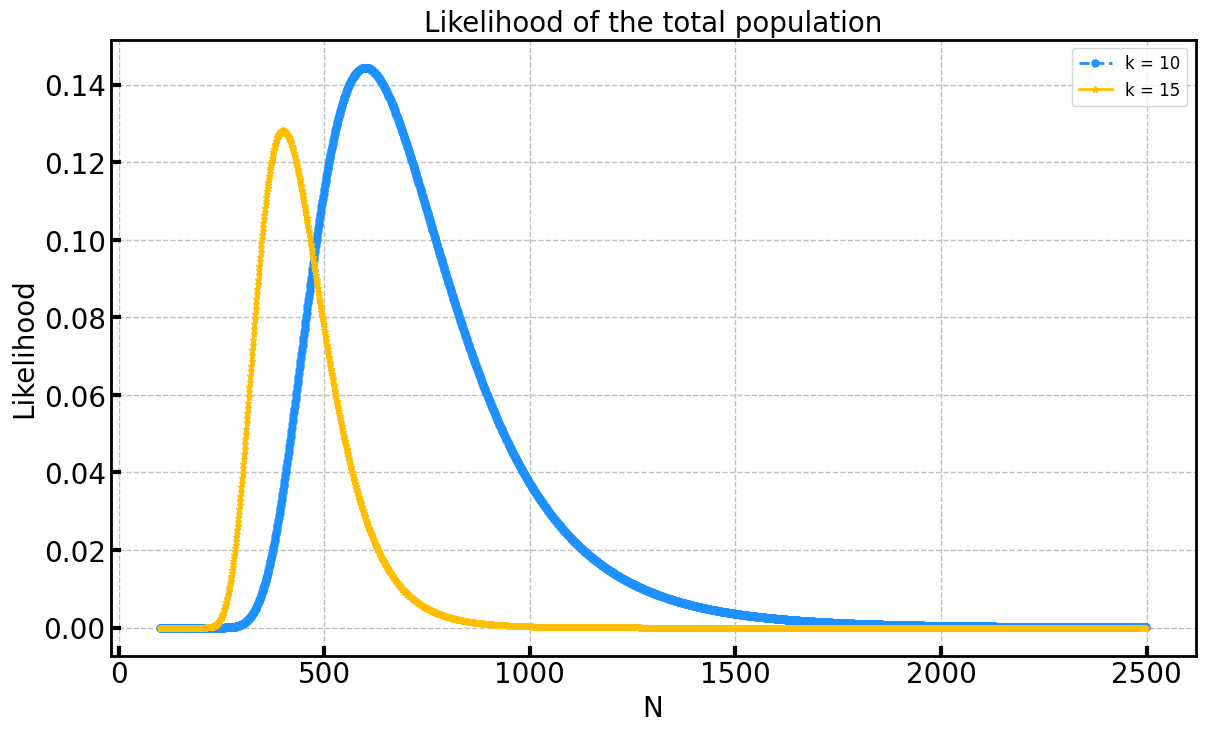

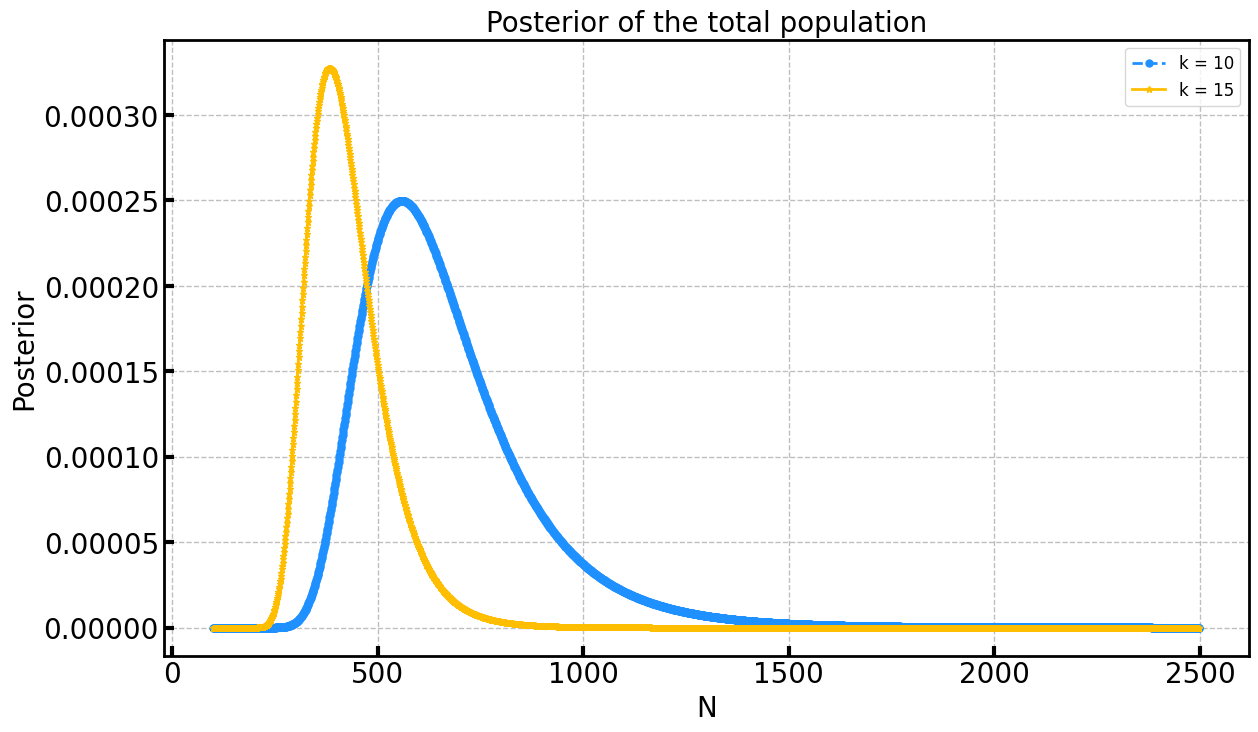

In [11]:
def populationFractional():
    N = np.arange(100,2500,1)
    n = 60  # quantity drawn in each trial
    K = 100 # the number of success states in the population
    k1 = 10 # the number of observed successes
    k2 = 15 # the number of observed successes
    llh1 = pmf(N, K, n, k1)
    llh2 = pmf(N, K, n, k2)
    marginal = 1
    prior1 = fractional(N)
    prior2 = fractional(N)
    p1 = getPosterior(llh1, prior1, marginal)
    p2 = getPosterior(llh2, prior1, marginal)
    max_p1 = np.argmax(p1)
    max_N_1 = N[max_p1]

    print(max_N_1)
    plotLLH(N, llh1, llh2, 'k = 10', 'k = 15')
    plotPosterior(N, p1, p2, 'k = 10', 'k = 15')


populationFractional()

In [16]:
def popRatioInLake(mu, sig, label):
    fig, ax = plt.subplots(figsize=(14, 8))
    x_samples = np.random.normal(5000, 300, 100000)
    y_samples = np.random.normal(mu, sig, 100000)
    ratios = x_samples / y_samples
    
    ax.hist(ratios, bins=100, density=True, alpha=0.6, label = label)
    ax.set_title('Distribution of the ratio N(5000,300) / N(10,1)')
    ax.set_xlabel('Ratio')
    ax.set_ylabel('Density')
    ax.legend()
    print(f'mean: {ratios.mean():.2f}, std: {ratios.std():.2f}')
    return ratios.mean(), ratios.std()

In [ ]:
def popRatioInLake(mu, sig):
    x_samples = np.random.normal(5000, 300, 100000)
    y_samples = np.random.normal(mu, sig, 100000)
    ratios = x_samples / y_samples
    
    return ratios.mean(), ratios.std()

In [13]:
def Gaussian(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

In [14]:
def popFishKernel(N, llh1, llh2, mu, sig):
    marginal = 0.1
    prior1 = Gaussian(N, mu, sig) 
    prior2 = Gaussian(N, mu, sig)
    p1 = getPosterior(llh1, prior1, marginal)
    p2 = getPosterior(llh2, prior2, marginal)
    max_p1 = np.argmax(p1)
    max_N_1 = N[max_p1]

    print(max_N_1)
    plotLLH(N, llh1, llh2, 'fish(k = 4)', 'fish(k = 8)')
    plotPosterior(N, p1, p2, 'fish(k = 4)', 'fish(k = 8)')

mean: 504.85, std: 60.60
mean: 543.66, std: 34.69
496
max LLH : 375,   187
max posterior : 496,   460
540
max LLH : 375,   187
max posterior : 540,   530


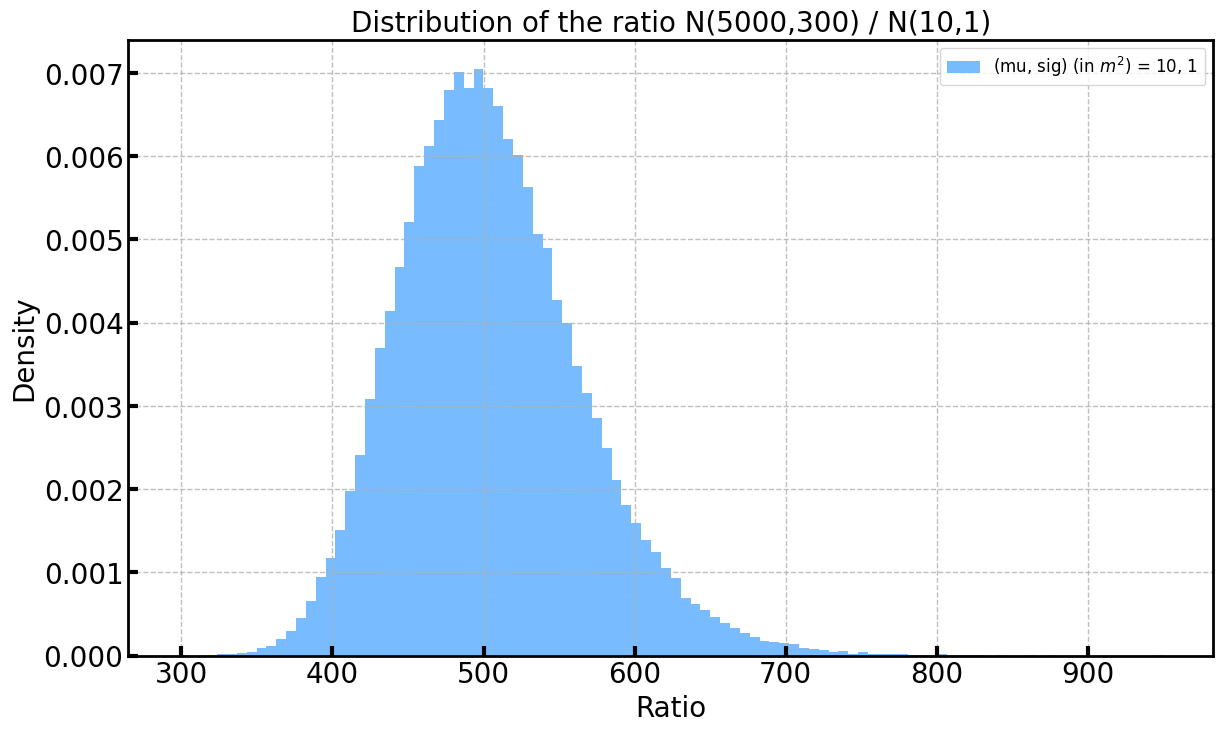

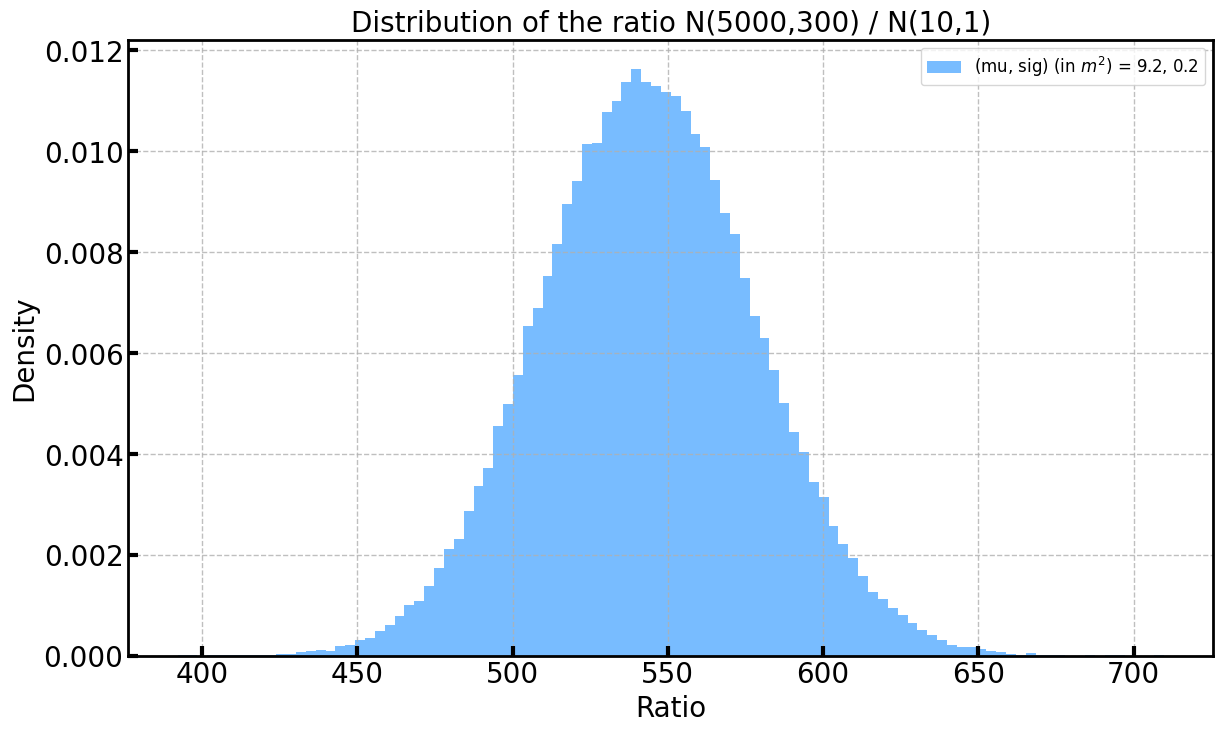

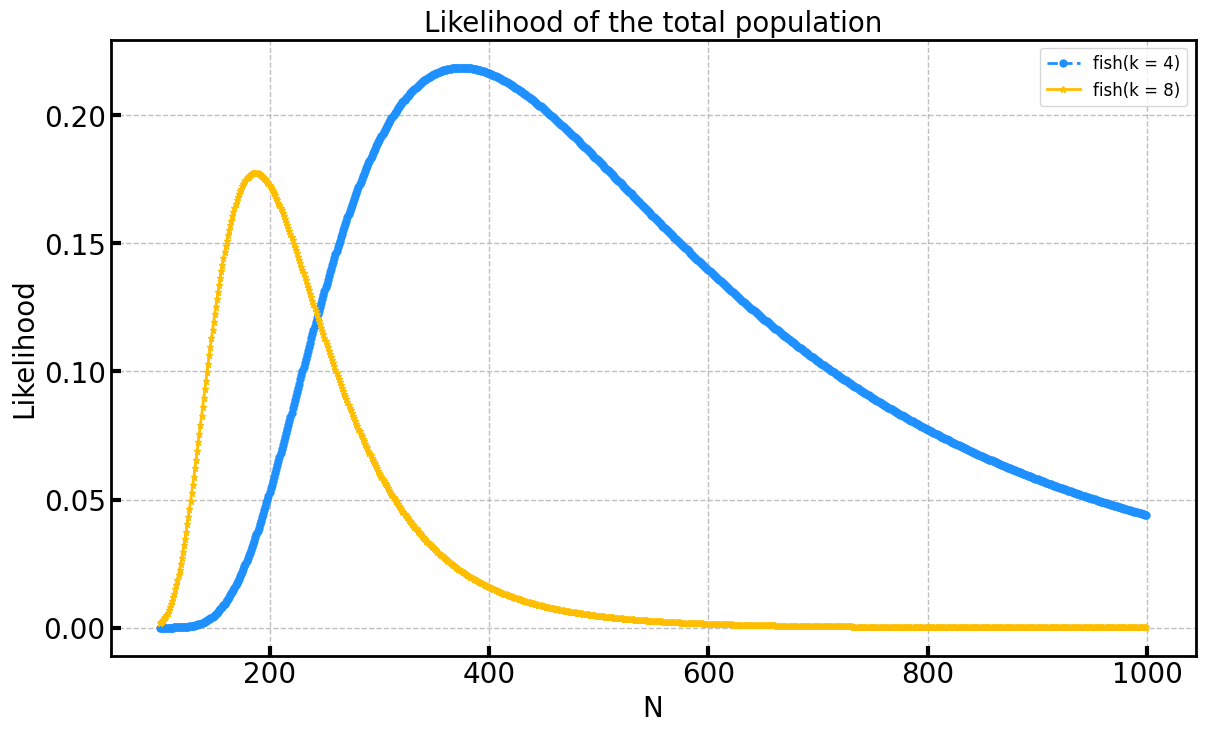

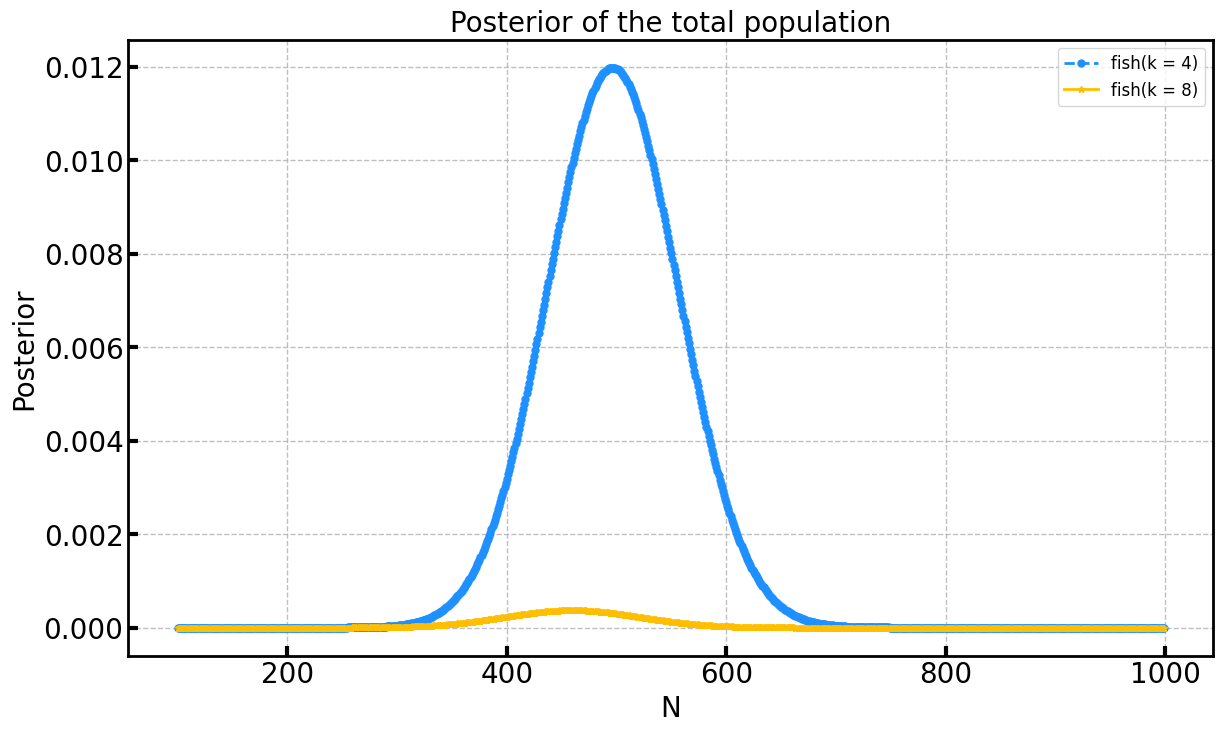

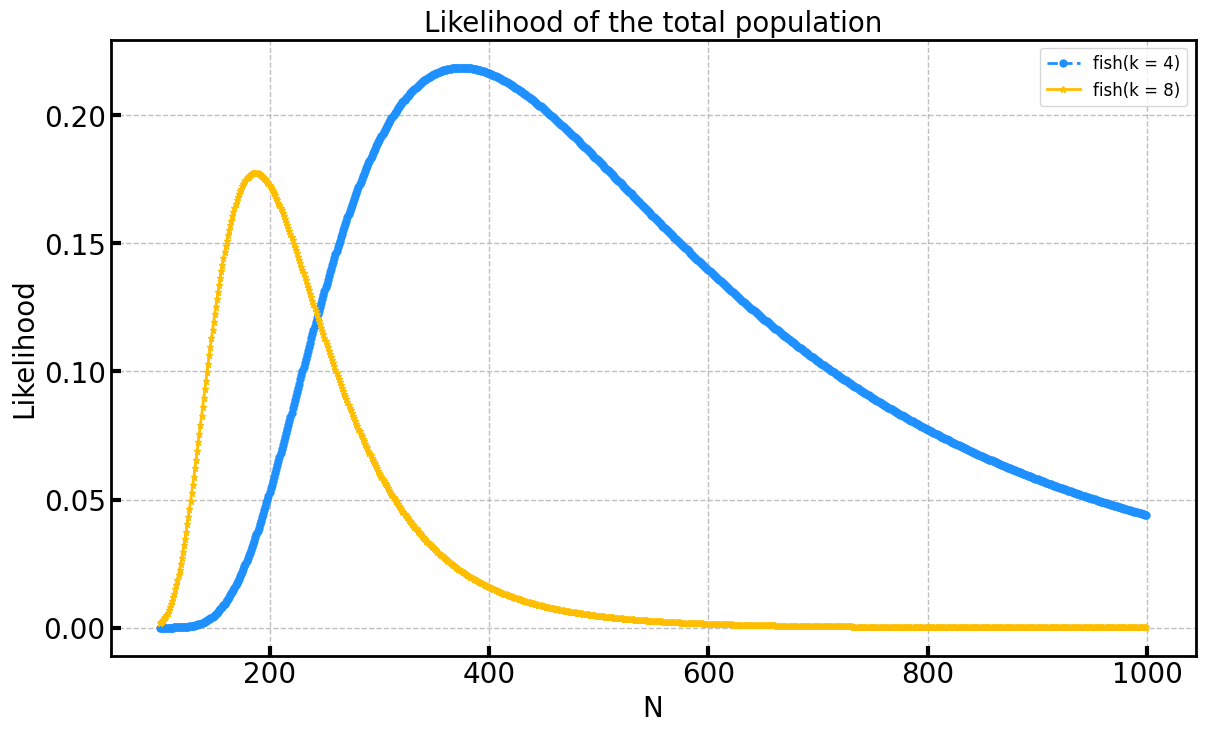

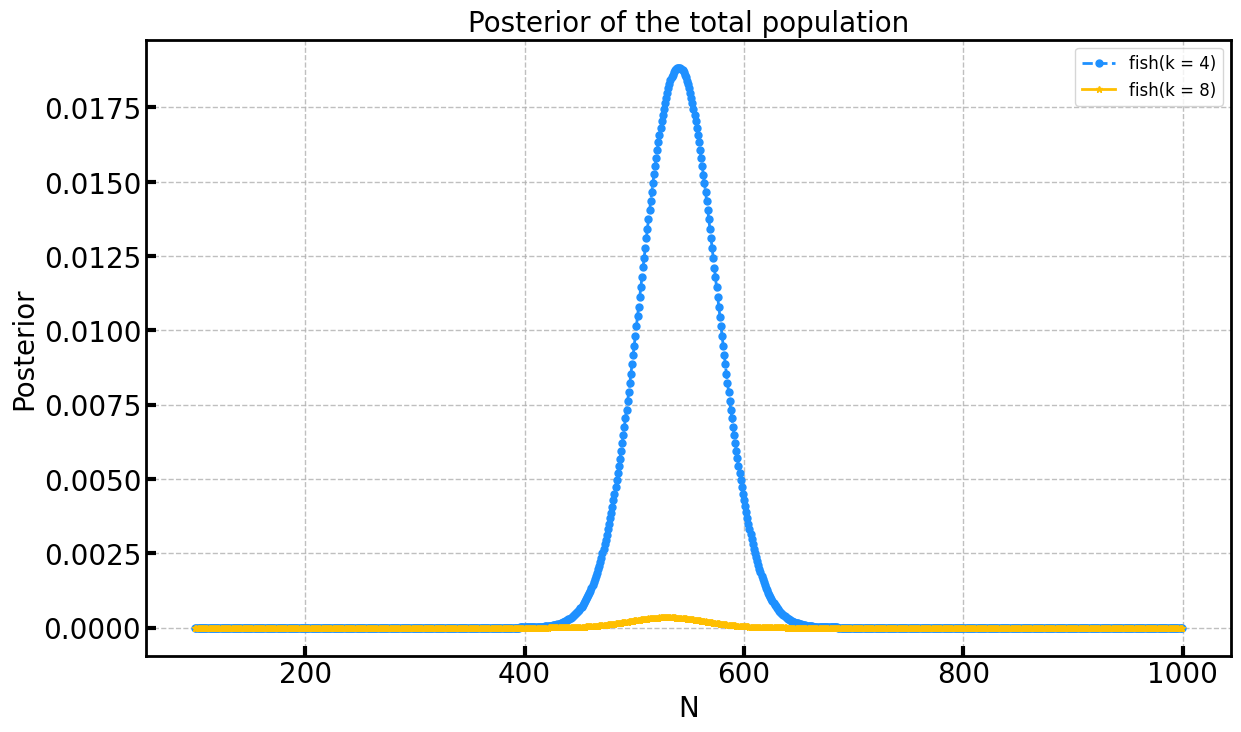

In [15]:
def populationFish():
    N = np.arange(100,1000,1)
    n = 30  # quantity drawn in each trial
    K = 50  # the number of success states in the population
    
    k1 = 4  
    k2 = 8  
    llh1 = pmf(N, K, n, k1)
    llh2 = pmf(N, K, n, k2)
    mu, sig = popRatioInLake(10, 1, r'(mu, sig) (in $m^2$) = 10, 1')
    mu_new, sig_new = popRatioInLake(9.2, 0.2, r'(mu, sig) (in $m^2$) = 9.2, 0.2')
    popFishKernel(N, llh1, llh2, mu, sig)
    popFishKernel(N, llh1, llh2, mu_new, sig_new)


populationFish()